In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [3]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")


import src.utils.setup_figures as figures
import src.utils.basic as utils

### Load Configs

In [22]:
from config import dir_config, main_config, s_probe_path

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)


# Try different encodings
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

for encoding in encodings:
    try:
        session_metadata = pd.read_csv(Path(processed_dir, "subject_metadata.csv"), index_col=None, encoding=encoding)
        print(f"Successfully read with encoding: {encoding}")
        break
    except UnicodeDecodeError as e:
        print(f"Failed with encoding: {encoding}, error: {e}")

Failed with encoding: utf-8, error: 'utf-8' codec can't decode byte 0xa7 in position 0: invalid start byte
Successfully read with encoding: latin1


# Load Aggregate data and preprocess trials

In [23]:
aggregate_data = pd.read_csv(Path(raw_dir, "aggregate_data.csv"), index_col=None)

#### Fill out the subject_metadata prior based on aggregate_data

In [24]:
for subject, medication in sorted(list(zip(session_metadata['subject_id'], session_metadata['treatment'])), key = lambda x: x[0]):
    # find the corresponding row in the aggregate data
    session_data = aggregate_data[(aggregate_data['subject'] == subject) & (aggregate_data['medication'] == medication.lower())]
    prior = np.unique(session_data['prior'])
    prior = prior[prior != 'eq']
    
    # in session_metadata, where subject and medication matches, update the prior
    
    current_idx = session_metadata[(session_metadata['subject_id'] == subject) & (session_metadata['treatment'] == medication)].index
    session_metadata.loc[current_idx, 'prior_condition'] = prior[0]
    session_metadata.loc[current_idx, 'file_name'] = np.unique(session_data['session_name'])[0]    

In [25]:
# Extract the relevant tremor variables that exist in the DataFrame columns
relevant_tremor_vars = [var for var in main_config.categorization.tremor if var in session_metadata.columns]
# Vectorized operation for summing
if relevant_tremor_vars:  
    # take row-wise mean of the tremor variables and store in a new column
    session_metadata['tremor_score'] = session_metadata[relevant_tremor_vars].mean(axis=1)

In [26]:
# save the updated session_metadata to the processed directory

session_metadata.to_csv(Path(processed_dir, "subject_metadata_updated.csv"), index=False)

##### Data rejection

In [5]:
valid_data = aggregate_data[aggregate_data['is_valid'] == 1]
# chose trials with minimum reaction time from main_config
valid_data = valid_data[valid_data['reaction_time'] >= main_config.behavior.min_rt]
valid_data = valid_data[valid_data['prior'] != 'eq']
valid_data['prior_color'].loc[valid_data['prior'] == 'eq'] = None
valid_data['prior_direction'].loc[valid_data['prior'] == 'eq'] = np.NaN

# remove data from subjects listed in main_config.manual_rejection
valid_data = valid_data[~valid_data['subject'].isin(main_config.manual_rejection)]

#### Direction and color conversion to prior condition

In [6]:
# Ensure valid_data is a DataFrame you intend to modify directly
left_prior_idx = valid_data['prior_direction'] == 'left'
right_prior_idx = valid_data['prior_direction'] == 'right'
green_prior_idx = valid_data['prior_color'] == 'green'
red_prior_idx = valid_data['prior_color'] == 'red'

# Renaming directions based on prior direction
valid_data.loc[left_prior_idx, 'target'] = valid_data.loc[left_prior_idx, 'target'].map({'left': 1, 'right': -1})
valid_data.loc[left_prior_idx, 'choice'] = valid_data.loc[left_prior_idx, 'choice'].map({'left': 1, 'right': -1})
valid_data.loc[right_prior_idx, 'target'] = valid_data.loc[right_prior_idx, 'target'].map({'left': -1, 'right': 1})
valid_data.loc[right_prior_idx, 'choice'] = valid_data.loc[right_prior_idx, 'choice'].map({'left': -1, 'right': 1})

# Renaming colors based on prior color
valid_data.loc[green_prior_idx, 'color'] = valid_data.loc[green_prior_idx, 'color'].map({'green': 1, 'red': -1})
valid_data.loc[red_prior_idx, 'color'] = valid_data.loc[red_prior_idx, 'color'].map({'green': -1, 'red': 1})


valid_data['signed_coherence'] = valid_data['coherence'] * valid_data['target']

#### Rejecting sessions based on allowed lapse rates

In [7]:
sessions = valid_data['session_name'].unique()

reject_sessions = []

for session in sessions:
    session_data = valid_data[valid_data['session_name'] == session]
    coh, psych, model, _, _ = utils.get_psychometric_data(session_data)
    
    
    if (model.coefs_['lapse_rate'] > main_config.behavior.max_lapse_rate) or model.coefs_['guess_rate'] > main_config.behavior.max_lapse_rate:
        reject_sessions.append(session)
        print(f"Subject: {session} rejected due to high lapse rate, \t\t {model.coefs_['lapse_rate']}, \t{model.coefs_['guess_rate']}")
        continue
    
valid_data = valid_data[~valid_data['session_name'].isin(reject_sessions)]
    

Subject: Brady_AJL_OFFmeds_gr.mat rejected due to high lapse rate, 		 0.34421542352371853, 	0.4340296428874369
Subject: Brady_AJL_ONmeds_rl.mat rejected due to high lapse rate, 		 0.3962838123266594, 	0.21727232620209153
Subject: Brady_LHO_OFFmeds_rl.mat rejected due to high lapse rate, 		 0.37032883038413256, 	0.11033872886578304
Subject: Brady_LHO_ONmeds_gl.mat rejected due to high lapse rate, 		 0.49999999999996203, 	0.272739785056627
Subject: Brady_MBY_OFFmeds_rr.mat rejected due to high lapse rate, 		 0.04932816168774892, 	0.10653835044816064
Subject: Brady_PAM_OFFmeds_gr.mat rejected due to high lapse rate, 		 0.10384794050858533, 	1.0000000000000072e-05
Subject: Brady_RBA_OFFmeds_gr.mat rejected due to high lapse rate, 		 0.24607979536021496, 	0.08335972890772636
Subject: Brady_RBA_ONmeds_rl.mat rejected due to high lapse rate, 		 0.15237676981857087, 	0.26246467078960106
Subject: Brady_RDE_OFFmeds_rr.mat rejected due to high lapse rate, 		 0.19404070320817607, 	0.19400275009295

In [8]:
# finding subjects who have both on and off medication sessions 
subject_sessions = valid_data.groupby('subject')['medication'].unique()

valid_subjects = []
for subject, sessions in subject_sessions.items():
    if len(sessions) == 2:
        valid_subjects.append(subject)
        
valid_data = valid_data[valid_data['subject'].isin(valid_subjects)]



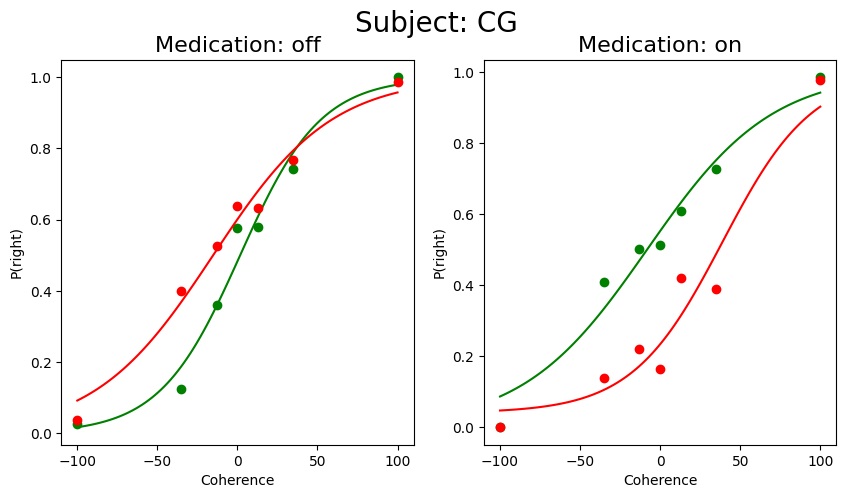

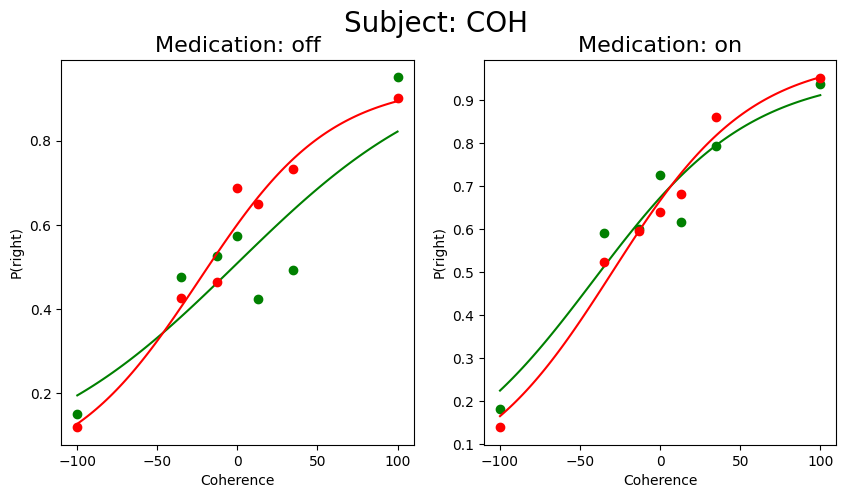

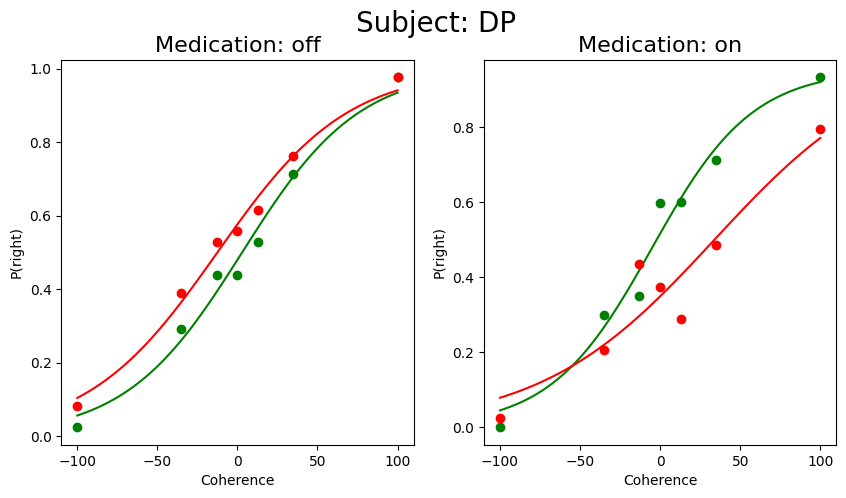

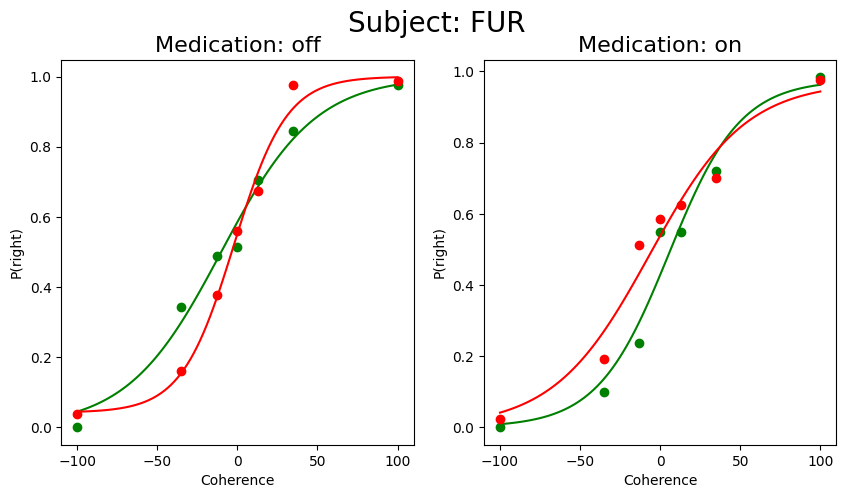

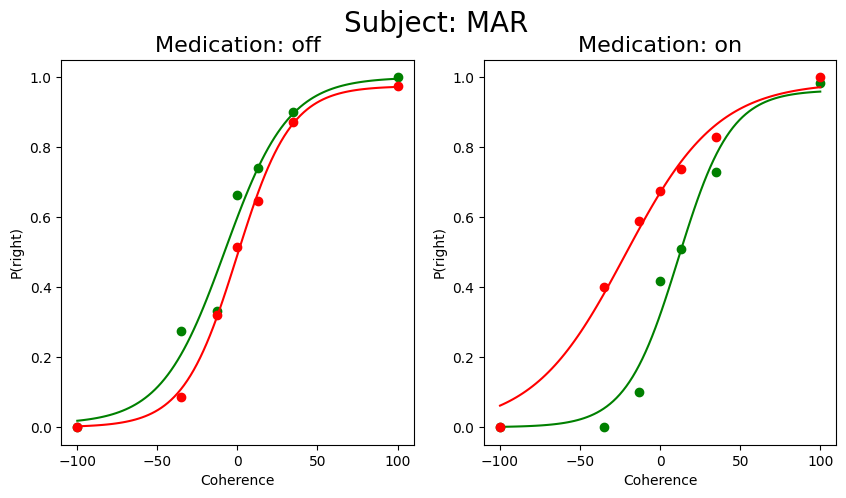

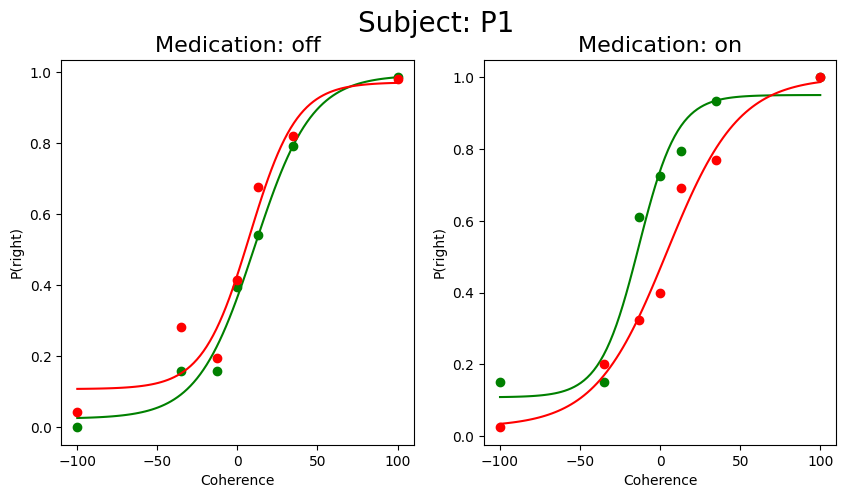

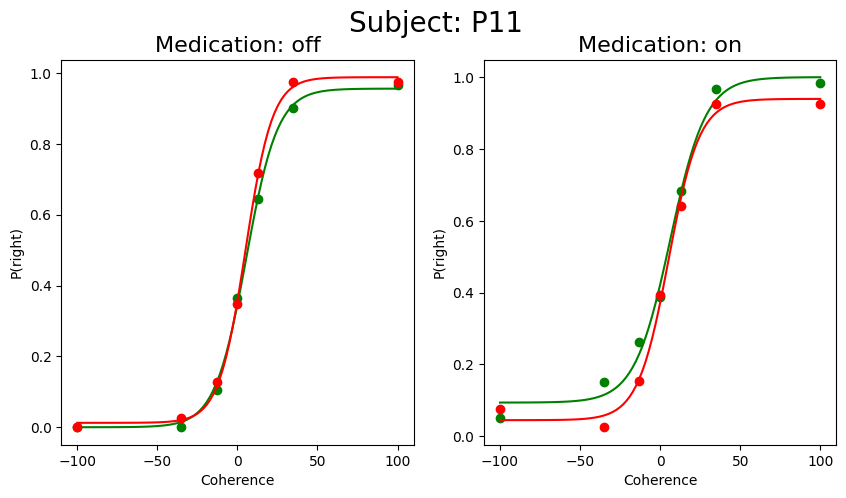

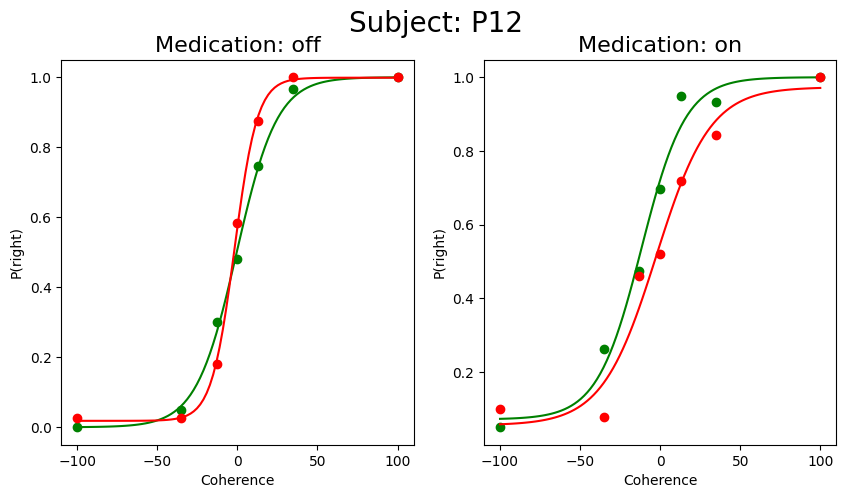

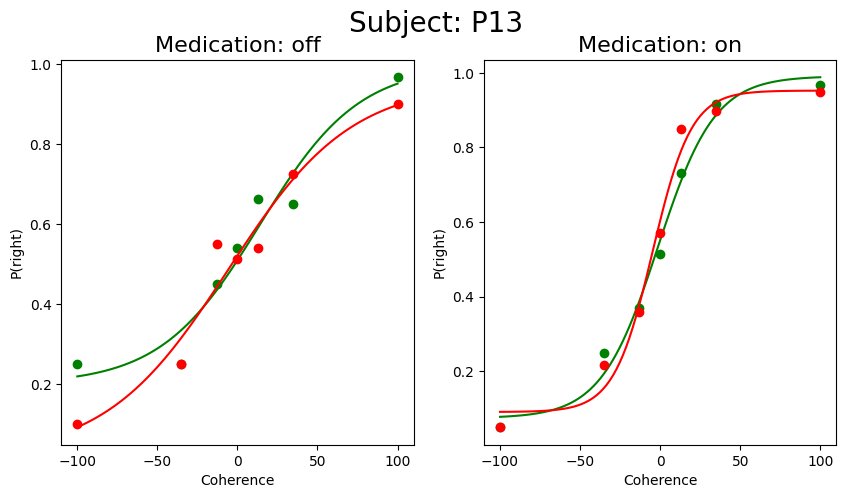

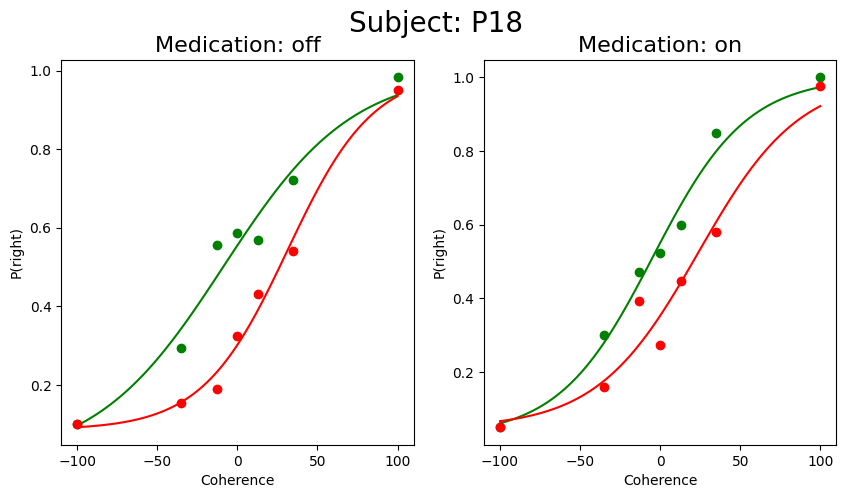

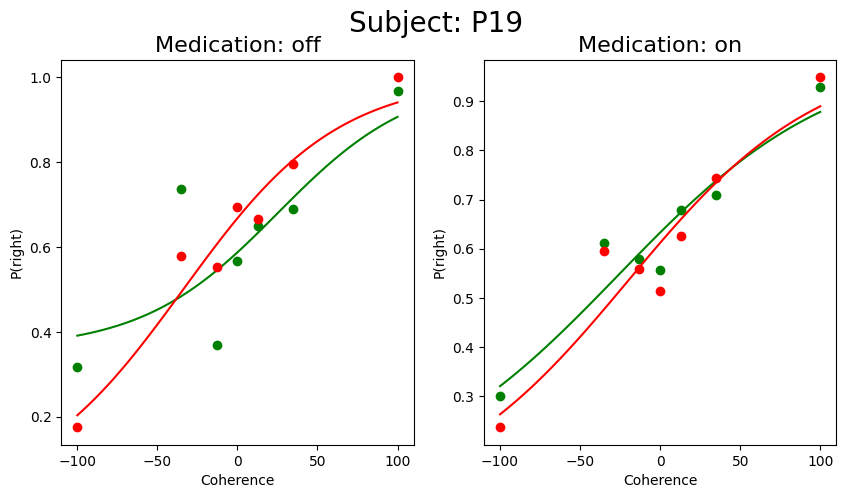

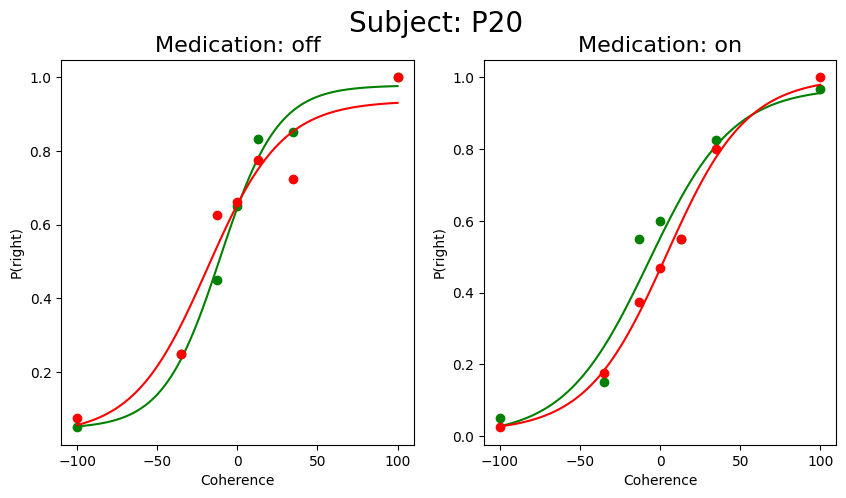

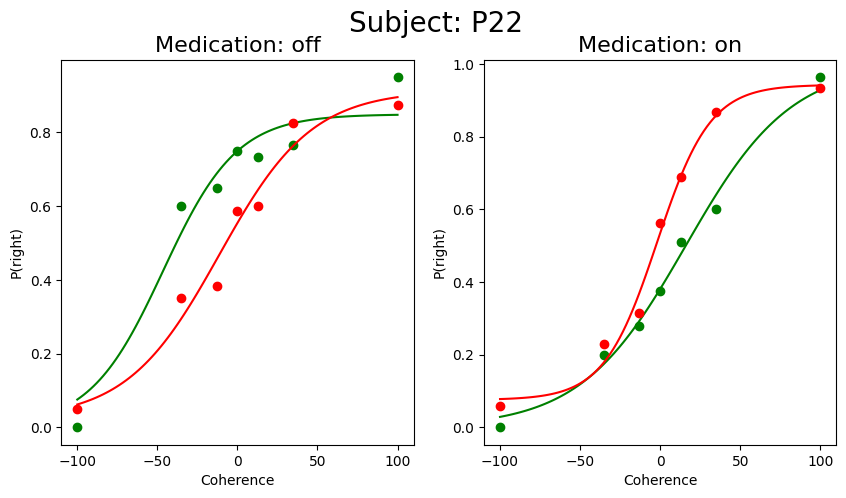

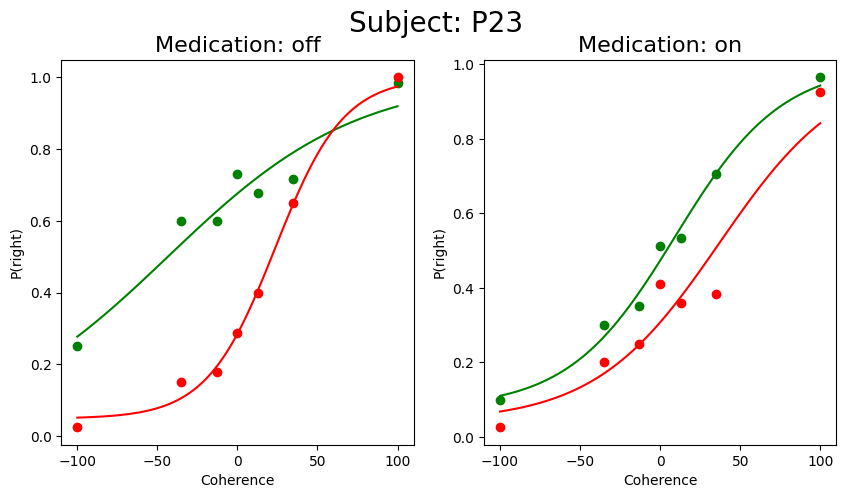

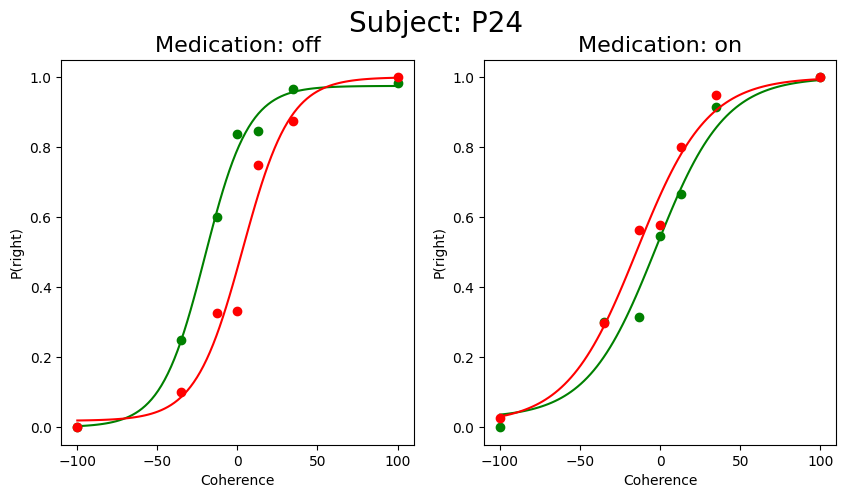

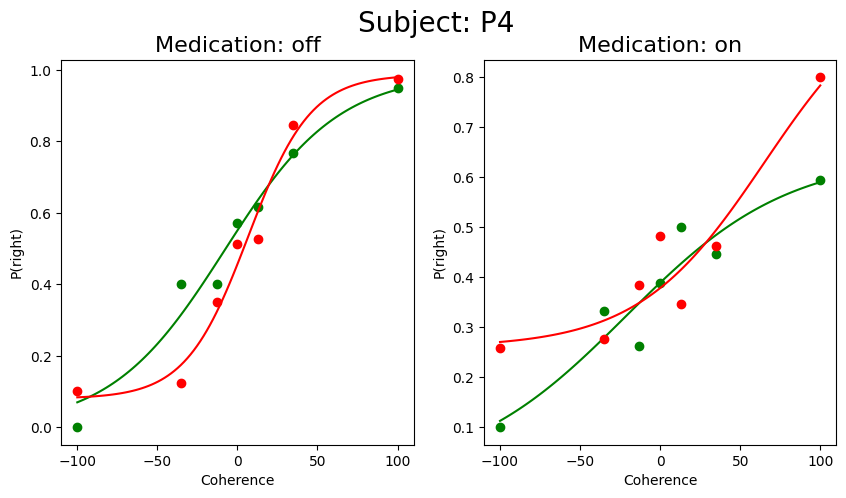

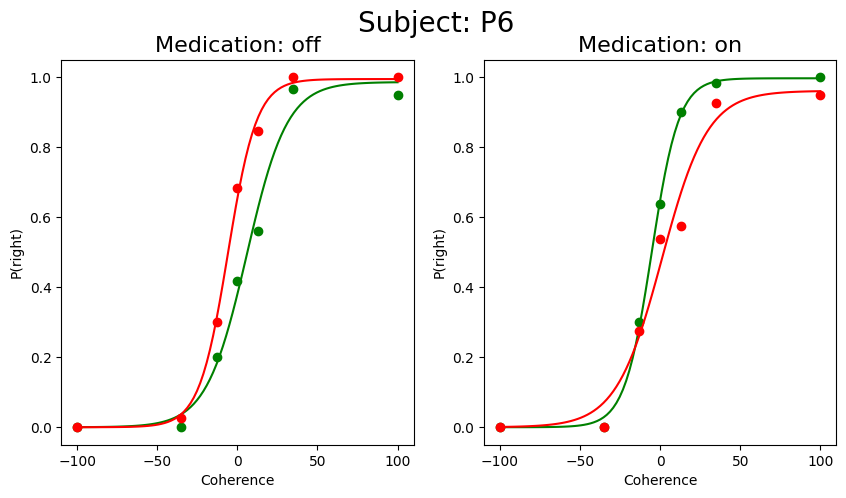

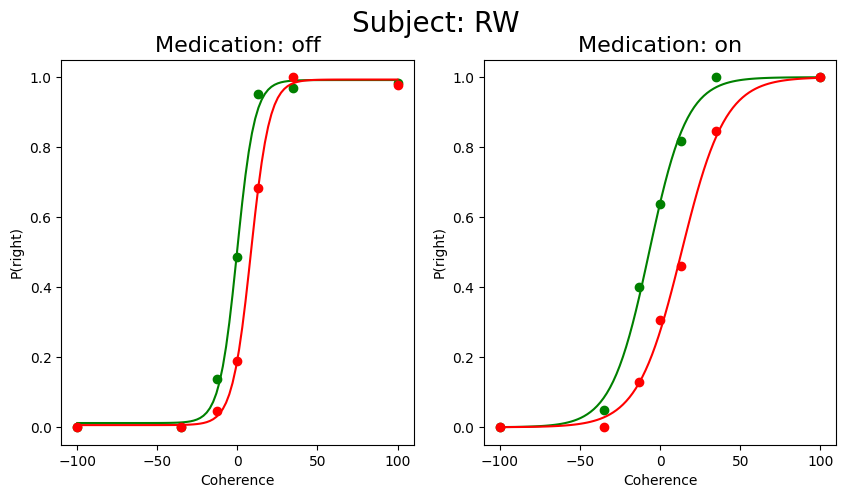

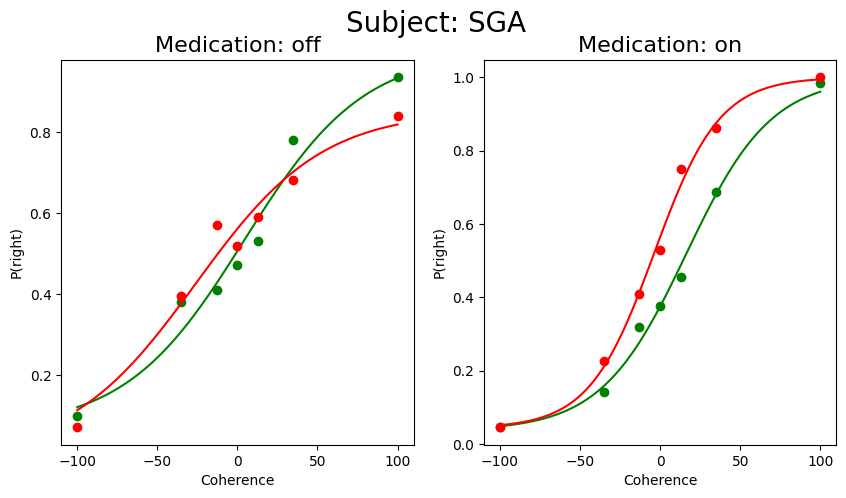

In [10]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors


for i, subject in enumerate(valid_subjects):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    subject_data = valid_data[valid_data['subject'] == subject]
    subject_data = subject_data.sort_values('medication')
    
    for idx, med in enumerate(subject_data['medication'].unique()):
        med_data = subject_data[subject_data['medication'] == med]
        coh, psych, model, x_hat, y_hat = utils.get_psychometric_data(med_data[med_data['color'] == 1])
        ax[idx].plot(coh, psych, 'go', label='Green')
        ax[idx].plot(x_hat, y_hat, 'g-', label='Green fit')
        coh, psych, model, x_hat, y_hat = utils.get_psychometric_data(med_data[med_data['color'] == -1])
        ax[idx].plot(coh, psych, 'ro', label='Red')
        ax[idx].plot(x_hat, y_hat, 'r-', label='Red fit')
        ax[idx].set_title(f"Medication: {med}", fontsize=16)
        ax[idx].set_xlabel('Coherence')
        ax[idx].set_ylabel('P(right)')
        
    fig.suptitle(f"Subject: {subject}", fontsize=20)